## Project - Dögg's working file

In [1]:
import pandas as pd
import pytz

#### Data pre-processing

In [2]:
data = pd.read_csv('EVChargingStationUsage.csv')
data.head()

/var/folders/y8/7qgmhhm95nd9c_b70tsnww880000gq/T/ipykernel_72894/2881118420.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('EVChargingStationUsage.csv')


,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,...,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,...,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,...,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,...,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,...,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


In [3]:
# Convert datetime columns to datetime objects and 
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce') # some values are incorrect, they will be converted to NaT and removed later
data['Total Duration (hh:mm:ss)'] = pd.to_timedelta(data['Total Duration (hh:mm:ss)'])
data['Charging Time (hh:mm:ss)'] = pd.to_timedelta(data['Charging Time (hh:mm:ss)'])

## Cleanup

In [4]:
# View missing values
#print(data.isna().sum())

In [5]:
# Remove columns where more than 8000 values are missing
threshold = 8000
cols_to_drop = data.columns[data.isna().sum() > threshold]
data = data.drop(columns=cols_to_drop)

# View
#print(data.isna().sum())

In [6]:
# Remove all rows with missing values
data = data.dropna()

# View
#print(data.isna().sum())

## Data preparation

In [7]:
# Convert timezone to UTC
# I have to convert the datetime to the same timezone, as there are too many different ones.
# Unique start and end time timezone combinations
#	PDT	PDT
#	PST	PST
#	PST	PDT
#	PDT	PST
#	UTC	PDT
#	UTC	PST
#	PDT	UTC
# Therefore, it would probably be best to convert to UTC first to calculate the hourly energy use and hourly charger occupation, 
# then switch back to US/Pacific for the day vs night and weekday vs weekend clustering analysis

# Map timezones: (pytz handles daytime savings)
tz_mapping = {
    'PDT': 'US/Pacific',
    'PST': 'US/Pacific',
    'UTC': 'UTC'
}

# Function for localizing timezone (adding it to datetime column)
def localize_to_timezone(row, datetime_col, tz_col):
    tz_name = row[tz_col]  # Get timezone string
    timezone = pytz.timezone(tz_mapping.get(tz_name))  # Map to pytz timezone string
    return row[datetime_col].tz_localize(timezone, ambiguous='NaT', nonexistent='NaT') # Localize datetime

# Apply the localization function to 'Start Date' and 'End Date'
data['Start Date Localized'] = data.apply(lambda row: localize_to_timezone(row, 'Start Date', 'Start Time Zone'), axis=1)
data['End Date Localized'] = data.apply(lambda row: localize_to_timezone(row, 'End Date', 'End Time Zone'), axis=1)

# Drop rows with non-existent 'spring forward' datetimes and those with ambiguous 'fall back' datetimes
data = data.dropna()

# Convert to UTC
data['Start Date UTC'] = pd.to_datetime(data['Start Date Localized'], utc=True)
data['End Date UTC'] = pd.to_datetime(data['End Date Localized'], utc=True)

## Calculate hourly energy use and hourly charger occupation / resample

Next up is calculating the hourly energy use and the hourly charger occupation.

So, I now have my time in UTC as events. I need to convert these events to multiple rows, as I need one row per hour

These are the relevant columns from row 1, let's use this as an example:
* Total Duration (hh:mm:ss)                     0 days 03:03:32
* Charging Time (hh:mm:ss)                      0 days 01:54:03
* Energy (kWh)                                         6.249457
* Start Date UTC                      2011-07-30 03:17:00+00:00
* End Date UTC                        2011-07-30 06:20:00+00:00

The Charging Time is 01:54:03, and the Total Duration is 0 days 03:03:32. And the Start Date UTC is 2011-07-30 03:17:00+00:00, and End Date UTC is 2011-07-30 06:20:00+00:00, and the Energy (kWh) is 6.249457.

### Plan
I want the hourly energy use to be calculated like this:

1. Convert 'Charging Time (hh:mm:ss)' to minutes: 0 days 01:54:03 = 114.05 min as 'Total Charging Time (min)' and 
'Total Duration (hh:mm:ss)' to minutes: 0 days 03:03:32 = 183.53

- Step 1.5: Remove those rows, where the Total Duration is greater than the Total Charging Time, if the difference is more than 1 minute. If less, set the Total Duration to be the Total Charging Time

2. Find charging per minute 'kWh per min': 'Energy (kWh)' / 'Total Charging Time (min)' = 6.249457 / 114.05 = 0.05479576502

3. This event has to be converted to 4 rows: where the 'Date UTC' is 2011-07-30 03:00:00+00:00, 2011-07-30 04:00:00+00:00, 
2011-07-30 05:00:00+00:00, and 2011-07-30 06:00:00+00:00

4. Figure out how many minutes were charging/occupied in each:
* 'Date UTC' : 'Charging Time (min)' : 'Duration (min)'
* 2011-07-30 03:00:00+00:00 : 60-17 = 43 : 60 - 17 = 43
* 2011-07-30 04:00:00+00:00 : 60-0 (if sum of charging min does not exceed 'Total Charging Time (min)') = 60 : 60 - 0 (if sum of duration min does not exceed 'Total Duration (min)')= 60
* 2011-07-30 05:00:00+00:00 : 60-0 (if sum of charging min does not exceed 'Total Charging Time (min)') = 60, but exceeds limit of 114, so Charging Time (min) = 114.05 - 17 - 60 = 37.05 : 60 - 0 (if sum of duration min does not exceed 'Total Duration (min)')= 60
* 2011-07-30 06:00:00+00:00 : 20 (if sum of charging min does not exceed 'Total Charging Time (min)') = 60, but this exceeds limit of 114, so Charging Time (min) = 114.05 - 17 - 60 - 37.05 = 0 : 20

5. This gives the following columns and rows, where we add hourly energy consumption and hourly charger occupation:
* 'Date UTC' : 'Charging Time (min)' : 'Duration (min)' : 'Hourly Energy Consumption (kWh)' : 'Hourly Charger Occupation (h)'
* 2011-07-30 03:00:00+00:00 : 43 : 43 : Charging Time (min) * kWh per min = 43 * 0.05479576502 = 2.3562178959 : 43/60 = 0.717 
* 2011-07-30 04:00:00+00:00 : 60 : 60 : Charging Time (min) * kWh per min = 60 * 0.05479576502 = 3.2877459012 : 60/60 = 1 
* 2011-07-30 05:00:00+00:00 : 37.05 : 60 : Charging Time (min) * kWh per min = 37.05 * 0.05479576502 = 2.03018309399 : 60/60 = 1
* 2011-07-30 06:00:00+00:00 : 0 : 20 : Charging Time (min) * kWh per min = 0 * 0.05479576502 = 0 : 20/60 = 0.333


In [8]:
# Step 1: Converting Charging Time and Total Duration to minutes:
data['Total Charging Time (min)'] = pd.to_timedelta(data['Charging Time (hh:mm:ss)']).dt.total_seconds() / 60
data['Total Duration (min)'] = pd.to_timedelta(data['Total Duration (hh:mm:ss)']).dt.total_seconds() / 60

# Step 1.5: Remove those rows, where the Total Duration is greater than the Total Charging Time, 
#    if the difference is more than 1 minute. If less, set the Total Duration to be the Total Charging Time

# Calculate the difference between Total Duration and Total Charging Time
difference = data['Total Charging Time (min)'] - data['Total Duration (min)']

# Remove rows where the difference is greater than 1 minute
data = data[difference <= 1]

# Update Total Duration to match Total Charging Time if the difference is less than or equal to 1 minute
data.loc[(difference <= 1) & (difference > 0), 'Total Duration (min)'] = data['Total Charging Time (min)']

In [9]:
# Step 2: Find charging per minute 'kWh per min'
data['kWh per min'] = data['Energy (kWh)'] / data['Total Charging Time (min)']

In [10]:
# Extra step: Add id column to original dataframe, so I don't have to copy all values in all rows:
data['unique_id'] = range(len(data))

In [11]:
# Step 3, 4, 5: 

# Function for counting the _ minutes. Used for charging and duration
def count_minutes(start_date, current_hour, total__time, minutes_):
    if (start_date.replace(minute=0, second=0) == current_hour):
        if ((60 - start_date.minute) > total__time):
            _min_in_hour = total__time
        else:
            _min_in_hour = 60 - start_date.minute
    elif ((minutes_ + 60) <= total__time):
        _min_in_hour = 60
    elif ((minutes_ + 60) > total__time):
        _min_in_hour = total__time - minutes_
    else:
        print("You missed something :P")
    return _min_in_hour

# Funtion for splitting events into multiple rows
def split_event_into_hours(row):
    start_date = row['Start Date UTC']
    end_date = row['End Date UTC']
    total_charging_time = row['Total Charging Time (min)']
    total_duration = row['Total Duration (min)']
    kWh_per_min = row['kWh per min']
    
    # Create a list of hours
    hourly_rows = []
    
    # Calculate minute totals
    minutes_charged = 0
    minutes_occupied = 0
    
    # Initialize current and iterate over all the hours
    current_hour = start_date.replace(minute=0, second=0)
    while current_hour < end_date:
        
        # Calculate minutes_in_hour
        charging_min_in_hour = count_minutes(start_date, current_hour, total_charging_time, minutes_charged)
        occupied_min_in_hour = count_minutes(start_date, current_hour, total_duration, minutes_occupied)
        
        # Calculate hourly energy consumption and charger occupation
        hourly_energy = charging_min_in_hour * kWh_per_min
        hourly_occupation = occupied_min_in_hour / 60  # Convert to hours
        
        # Append row
        hourly_rows.append({
            'Date UTC': current_hour,
            'Charging Time (min)': charging_min_in_hour,
            'Duration (min)': occupied_min_in_hour,
            'Hourly Energy Consumption (kWh)': hourly_energy,
            'Hourly Charger Occupation (h)': hourly_occupation,
            'Original Row ID': row['unique_id']
        })

        # Update counters
        minutes_charged += charging_min_in_hour
        minutes_occupied += occupied_min_in_hour

        # Move to the next hour
        current_hour += pd.Timedelta(hours=1)

    return pd.DataFrame(hourly_rows)

# Apply the function and create a new dataframe
new_data = pd.concat(data.apply(split_event_into_hours, axis=1).tolist(), ignore_index=True)

## Final additions and merging the dataset
Add the Local US/Pacific time again, but this time with all data points having the same timezone.

Add dummies for night and weekend

Merge the new per hour (instead of per event) dataframe with the original dataframe, so that all features can be used even with the new structure.


In [12]:
# Create new column with US/Pacific time
new_data['Date Pacific'] = new_data['Date UTC'].dt.tz_convert('US/Pacific')

In [13]:
# Create dummy for night and weekend

# Night: check if time is between 18 and 6
new_data['Is Night'] = ((new_data['Date Pacific'].dt.hour >= 18) | (new_data['Date Pacific'].dt.hour < 6)).astype(int)

# Weekend: check if day is 5 or 6, aka weekend
new_data['Is Weekend'] = new_data['Date Pacific'].dt.dayofweek.isin([5, 6]).astype(int)

In [14]:
# Merge the dataframes.
merged_data = pd.merge(new_data, data, left_on='Original Row ID', right_on='unique_id', how='inner')

# Remove the unique_id column, as name is misleading, and the same information is in the Original Row ID column.
merged_data = merged_data.drop(columns=['unique_id'])


## Exploratory Analysis

This exploratory analysis will focus on analyzing the stations to see what can be done to improve the business. Are the port types not good, are there too many hoarders, or are there simply not enough chargers?

Start by grouping some of the stations. There are a couple of stations which are so close by each other that they have the same name, but different numbers, e.g. PALO ALTO CA / BRYANT #1 and PALO ALTO CA / BRYANT #2 etc. are grouped into one Base Station called PALO ALTO CA / BRYANT. This is done using regular expressions to match the pattern, so that the numbering can be removed from the Station Name. A summary dataframe, station_summary, with the number of charging points, the mean latitude and longitude, station name and base station name is created. And another summary dataframe, base_station_summary, with the number of charging points, the mean latitude and longitude, and the base station name is also created.

Then the base stations are mapped along with the number of charging points in each location.

P.S. I haven't move all my imports to the top, so that it's easier to see where they are being used.

In [15]:
import re

# Function for matching the numbering at the end of the Station Names
def extract_base_name(station_name):
    return re.sub(r'#?\s*\d+$', '', station_name).strip()

# There is an extra space in some records for the BRYANT station. Replace these, so number of Total Charging Points is more accurate.
merged_data['Station Name'] = merged_data['Station Name'].replace(
    'PALO ALTO CA / BRYANT # 1', 
    'PALO ALTO CA / BRYANT #1'
)

merged_data['Base Station Name'] = merged_data['Station Name'].apply(extract_base_name)
station_ports = merged_data.groupby(['Base Station Name', 'Station Name', 'Port Type', 'Port Number']).size().reset_index(name='Count')
#print(station_ports)

temp_base_station_ports = station_ports.groupby(['Base Station Name', 'Port Type', 'Port Number']).size().reset_index(name='Count')
#print(temp_base_station_ports)

base_station_ports = temp_base_station_ports.groupby(['Base Station Name', 'Port Type'])['Count'].sum().reset_index
#print(base_station_ports)

# Group data step by step, to ensure that all counts/sums stay correct
station_ports_summary = merged_data.groupby(['Base Station Name', 'Station Name', 'Port Type', 'Port Number']).agg(
    Total_Charging_Points=('Port Number', 'nunique'),
    Latitude=('Latitude', 'mean'),
    Longitude=('Longitude', 'mean'),
    Base_Station_Name=('Base Station Name', 'first')
).reset_index()
# print(station_ports_summary)

base_station_ports_summary = station_ports_summary.groupby(['Base Station Name', 'Port Type', 'Port Number']).agg(
    Total_Charging_Points=('Total_Charging_Points', 'sum'),
    Latitude=('Latitude', 'mean'),
    Longitude=('Longitude', 'mean')
).reset_index()
# print(base_station_ports_summary)

base_station_ports_type_summary = base_station_ports_summary.groupby(['Base Station Name', 'Port Type']).agg(
    Total_Charging_Points=('Total_Charging_Points', 'sum'),
    Latitude=('Latitude', 'mean'),
    Longitude=('Longitude', 'mean')
).reset_index()
# print(base_station_ports_type_summary)

base_station_summary = base_station_ports_type_summary.groupby('Base Station Name').agg(
    Total_Charging_Points=('Total_Charging_Points', 'sum'),
    Latitude=('Latitude', 'mean'),
    Longitude=('Longitude', 'mean')
).reset_index()
# print(base_station_summary)

In [16]:
import folium

# Use base_station_summary for map data
map_data = base_station_summary.copy()

# Use average location for the map
map_center = [map_data['Latitude'].mean(), map_data['Longitude'].mean()]
charging_map = folium.Map(location=map_center, zoom_start=14)

# Create the map
for _, row in map_data.iterrows():
    popup_info = f"""
    <b>Base Station Name:</b> {row['Base Station Name']}<br>
    <b>Total Charging Points:</b> {row['Total_Charging_Points']}
    """
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_info,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(charging_map)

# Display
charging_map


/Users/doggtyril/42577_Introduction_to_Business_Analytics__Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Calculate utilization rate for the different Base Stations
The utilization rate is calculated by grouping the merged_data based on the base station, port type and hour, in which the 'Hourly Energy Consumption (kWh)' and the 'Hourly Charger Occupation (h)' are summed. The total plugged-in (but not charging) time is also calculated. This is then plotted, to give an overview of the data usage in the different locations.

The assumptions here are partly the same as previously, when the merged_data dataframe was created. One is that the energy usage is constant whilst a car is charging.

##### Assumptions about number of Total Charging Points.
The number of charging points is calculated based on the number of unique combinations of Base Station Name, Station Name (which is numbered), Port Type and Port Number. This produces a number, which is constant throughout the entire time period, which means that we are assuming that this number stays constant. However, there are clear indications that this assumption may not be correct that can be seen by looking at the Utilization graph below. Another assumption is that the number of charging stations and the port types also stay constant throughout the years which the data spans.

In [17]:
merged_data['Plugged-In Not Charging (h)']=(merged_data['Duration (min)']-merged_data['Charging Time (min)'])/60
merged_data['Plugged-In Charging (h)']=(merged_data['Charging Time (min)'])/60

In [18]:
per_hour_sums = merged_data.groupby(['Base Station Name', 'Port Type', 'Date Pacific']).agg(
    Energy_Consumption_Sum_kWh=('Hourly Energy Consumption (kWh)', 'sum'),
    Charger_Occupation_Sum_h=('Hourly Charger Occupation (h)', 'sum'),
    Plugged_In_Not_Charging_Sum_h=('Plugged-In Not Charging (h)', 'sum'),
    Plugged_In_Charging_Sum_h=('Plugged-In Charging (h)', 'sum')
).reset_index()
#print(per_hour_sums)

In [19]:
# Merge the dataframes.
station_utilization_data = pd.merge(per_hour_sums, base_station_ports_type_summary, left_on=['Base Station Name', 'Port Type'], right_on=['Base Station Name', 'Port Type'], how='inner')

# print(station_utilization_data.head())
# print(station_utilization_data.info())

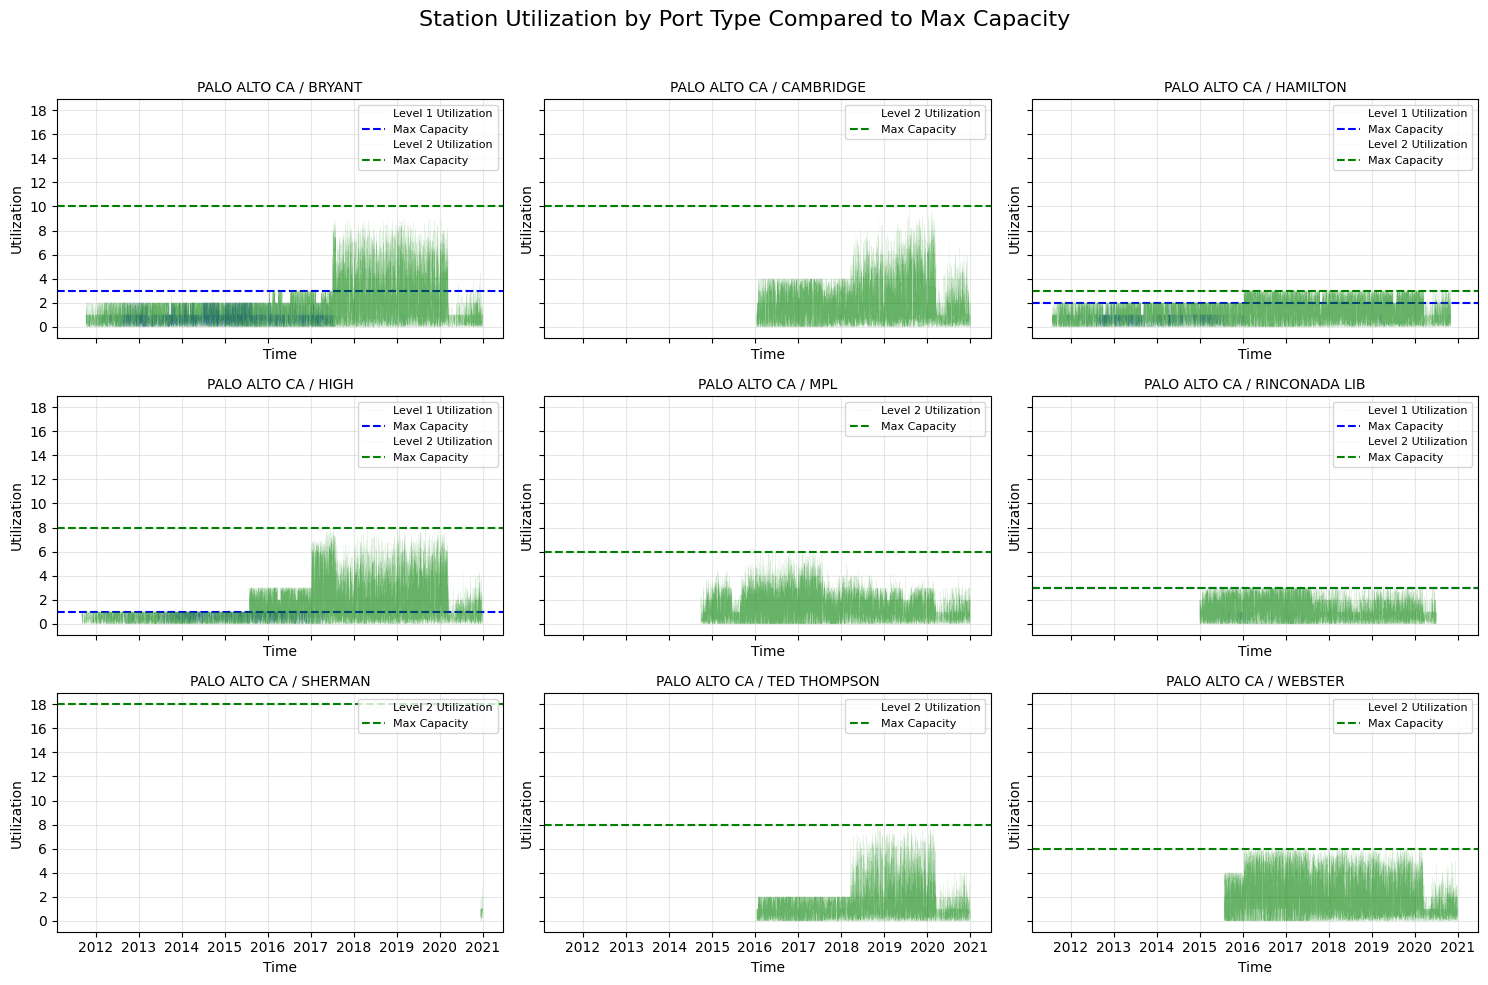

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Define consistent colors for Port Types
color_map = {'Level 1': 'blue', 'Level 2': 'green'}

# Get the Base Station Names
stations_to_plot = station_utilization_data['Base Station Name'].unique()[:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Station Utilization by Port Type Compared to Max Capacity', fontsize=16)

for i, station in enumerate(stations_to_plot):
    ax = axes[i // 3, i % 3]
    station_data = station_utilization_data[station_utilization_data['Base Station Name'] == station]
    
    # Plot utilization for each port type
    for port_type in station_data['Port Type'].unique():
        port_data = station_data[station_data['Port Type'] == port_type]
        
        # Extract the max capacity for the port type (first value of 'Total_Charging_Points')
        max_capacity = port_data['Total_Charging_Points'].iloc[0]
        
        # Calculate utilization rate
        utilization_rate = port_data['Plugged_In_Charging_Sum_h']
        
        # Plot utilization rate with consistent color
        ax.plot(
            port_data['Date Pacific'], 
            utilization_rate, 
            label=f'{port_type} Utilization', 
            color=color_map[port_type], 
            alpha=0.6,
            linewidth=0.05
        )
        
        # Add a horizontal line for max capacity
        ax.axhline(max_capacity, color=color_map[port_type], linestyle='--', label='Max Capacity')
    
    # Set y-axis to display only integers
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set titles and labels
    ax.set_title(station, fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel('Utilization')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.3)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.show()


Comments about the graphs:
- Many stations are almost at full capacity a large part of the time, like HIGH, HAMILTON, RINCONADA LIB and WEBSTER. Of these, HIGH, HAMILTON, and WEBSTER are fairly close to each other. But the BRYANT station, which is not at full capacity, is also close. So it would make sense to get some customers to charge their cars there instead. RINCONADA LIB is quite isolated at at quite full capacity, so it would make sense to add additional chargers here.
- TED THOMPSON, SHERMAN, and CAMBRIDGE are also quite close to each other, but these are not at max capacity. It also seems like SHERMAN might be a newer location, as there is no data from prior to the end of 2020. 
- This dataset also seems like it was affected by the Covid pandemic, as there is a clear drop in utilization at the start of 2020. This makes it more difficult to do any sort of analysis on this dataset, where prediction is the goal.

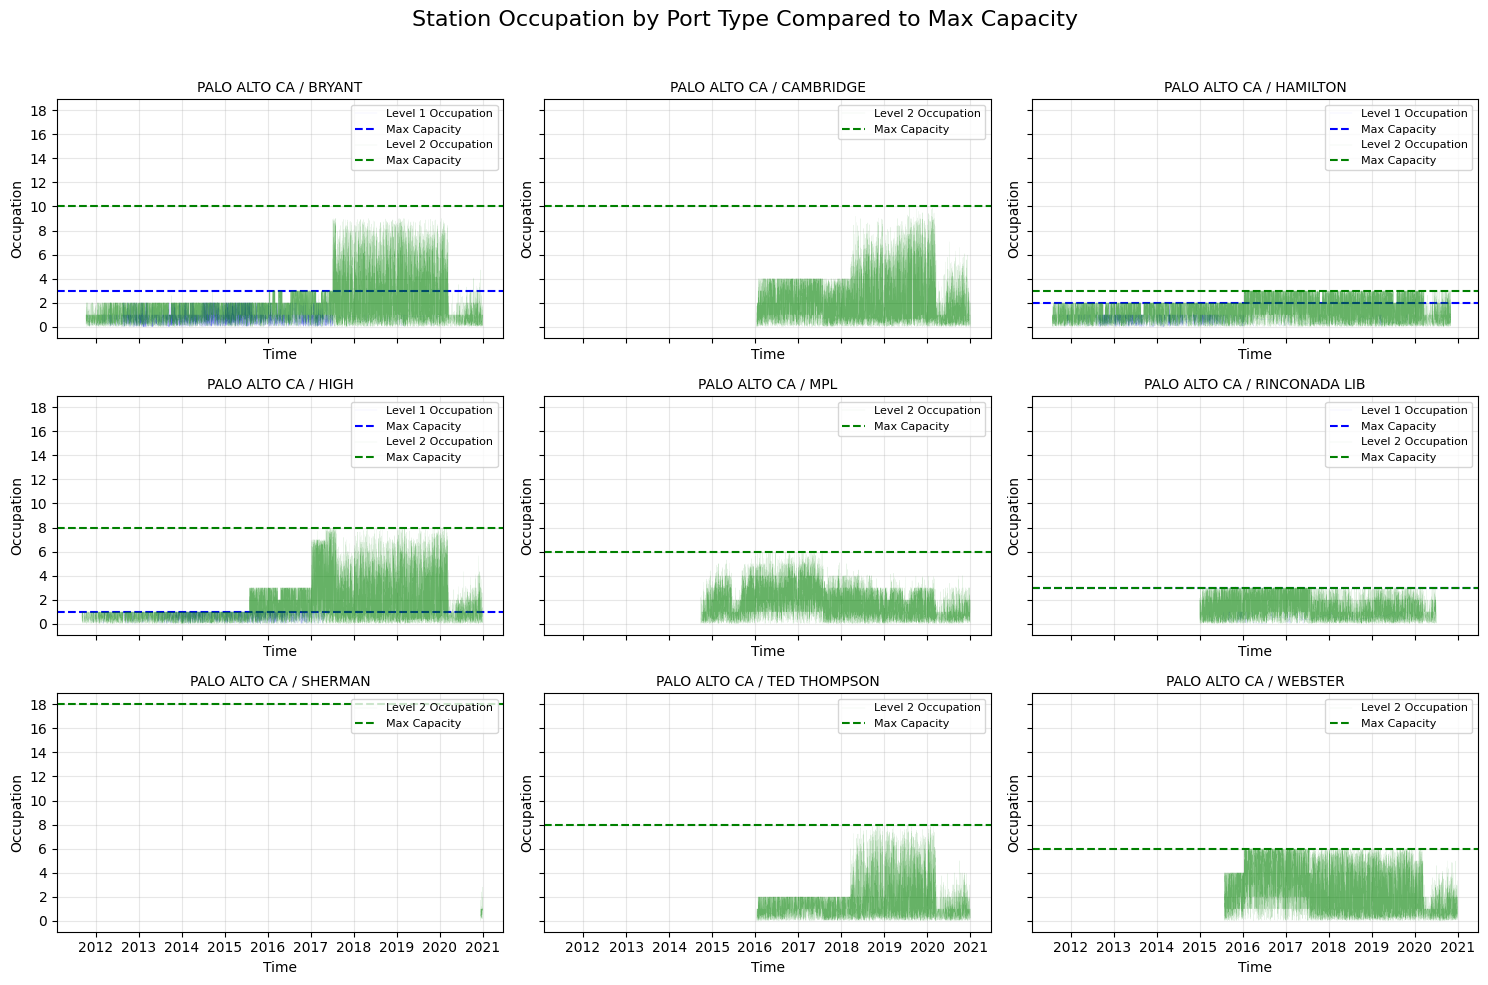

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Define consistent colors for Port Types
color_map = {'Level 1': 'blue', 'Level 2': 'green'}

# Get the Base Station Names
stations_to_plot = station_utilization_data['Base Station Name'].unique()[:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Station Occupation by Port Type Compared to Max Capacity', fontsize=16)

for i, station in enumerate(stations_to_plot):
    ax = axes[i // 3, i % 3]
    station_data = station_utilization_data[station_utilization_data['Base Station Name'] == station]
    
    # Plot occupation for each port type
    for port_type in station_data['Port Type'].unique():
        port_data = station_data[station_data['Port Type'] == port_type]
        
        # Extract the max capacity for the port type (first value of 'Total_Charging_Points')
        max_capacity = port_data['Total_Charging_Points'].iloc[0]
        
        # Calculate occupation rate
        occupation_rate = port_data['Charger_Occupation_Sum_h']
        
        # Plot occupation rate with consistent color
        ax.plot(
            port_data['Date Pacific'], 
            occupation_rate, 
            label=f'{port_type} Occupation', 
            color=color_map[port_type], 
            alpha=0.6,
            linewidth=0.05
        )
        
        # Add a horizontal line for max capacity
        ax.axhline(max_capacity, color=color_map[port_type], linestyle='--', label='Max Capacity')
    
    # Set y-axis to display only integers
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set titles and labels
    ax.set_title(station, fontsize=10)
    ax.set_xlabel('Time')
    ax.set_ylabel('Occupation')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.3)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.show()


It seems like the capacity at the BRYANT station might have been calculated incorrectly. But it is calculated according to the prementioned assumptions.

This also shows, that most of these stations are quite busy a large part of the time. Which is what we will take a closer look at next.

In [22]:
# Group by Base Station Name and calculate utilization metrics
station_capacity_analysis = station_utilization_data.groupby(['Base Station Name', 'Port Type']).agg(
    Average_Utilization=('Charger_Occupation_Sum_h', lambda x: (x / station_utilization_data['Total_Charging_Points']).mean() * 100),  # Average utilization as a percentage
    Max_Utilization=('Charger_Occupation_Sum_h', lambda x: (x / station_utilization_data['Total_Charging_Points']).max() * 100),      # Maximum utilization as a percentage
    Percent_Above_90=('Charger_Occupation_Sum_h', lambda x: ((x / station_utilization_data['Total_Charging_Points']) > 0.9).mean() * 100),  # % of hours above 90% utilization
    Hours_Above_90=('Charger_Occupation_Sum_h', lambda x: ((x / station_utilization_data['Total_Charging_Points']) > 0.9).sum())  # Total hours above 90% utilization
).reset_index()

# Sort by highest percentage of time above 90% utilization
most_at_capacity = station_capacity_analysis.sort_values('Percent_Above_90', ascending=False)

# Display the top stations
print(most_at_capacity)


               Base Station Name Port Type  Average_Utilization  \
4        PALO ALTO CA / HAMILTON   Level 2            51.536909   
9   PALO ALTO CA / RINCONADA LIB   Level 2            49.480128   
12        PALO ALTO CA / WEBSTER   Level 2            46.928751   
5            PALO ALTO CA / HIGH   Level 1            72.894774   
6            PALO ALTO CA / HIGH   Level 2            22.621236   
7             PALO ALTO CA / MPL   Level 2            30.568060   
11   PALO ALTO CA / TED THOMPSON   Level 2            20.775676   
2       PALO ALTO CA / CAMBRIDGE   Level 2            22.534448   
3        PALO ALTO CA / HAMILTON   Level 1            25.067428   
0          PALO ALTO CA / BRYANT   Level 1            27.649550   
1          PALO ALTO CA / BRYANT   Level 2            18.717598   
8   PALO ALTO CA / RINCONADA LIB   Level 1            25.022727   
10        PALO ALTO CA / SHERMAN   Level 2             4.990141   

    Max_Utilization  Percent_Above_90  Hours_Above_90  
4    

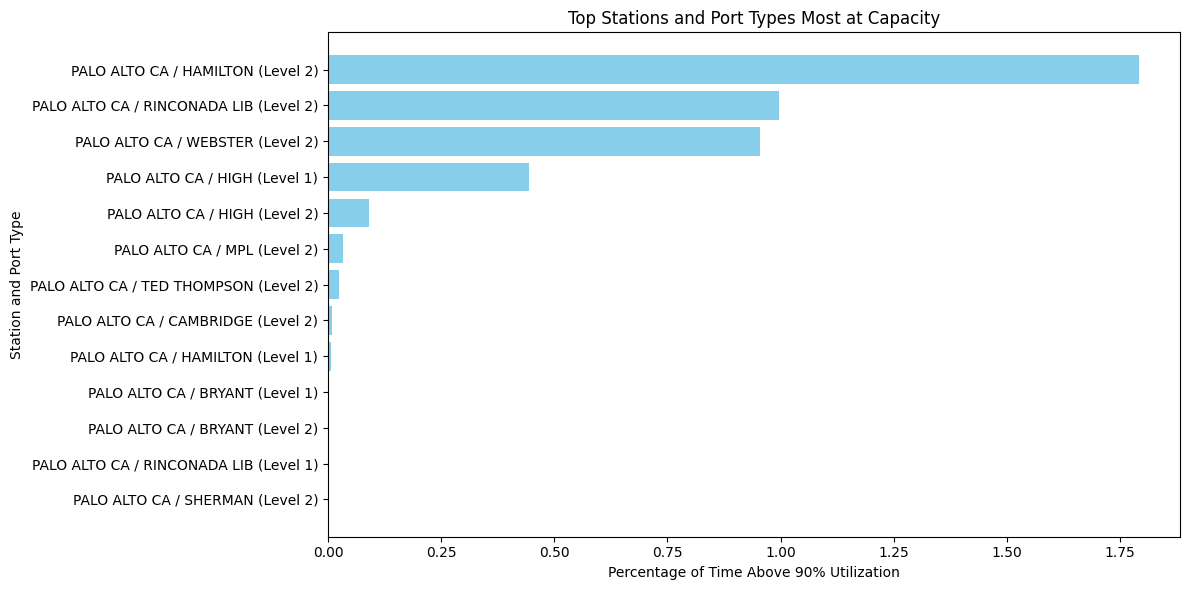

In [23]:
import matplotlib.pyplot as plt

# Combine Base Station Name and Port Type for y-axis labels
most_at_capacity['Station_Port'] = most_at_capacity['Base Station Name'] + " (" + most_at_capacity['Port Type'] + ")"

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.barh(most_at_capacity['Station_Port'], most_at_capacity['Percent_Above_90'], color='skyblue')

# Add labels and title
plt.xlabel('Percentage of Time Above 90% Utilization')
plt.ylabel('Station and Port Type')
plt.title('Top Stations and Port Types Most at Capacity')

# Flip the y-axis for better readability
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()


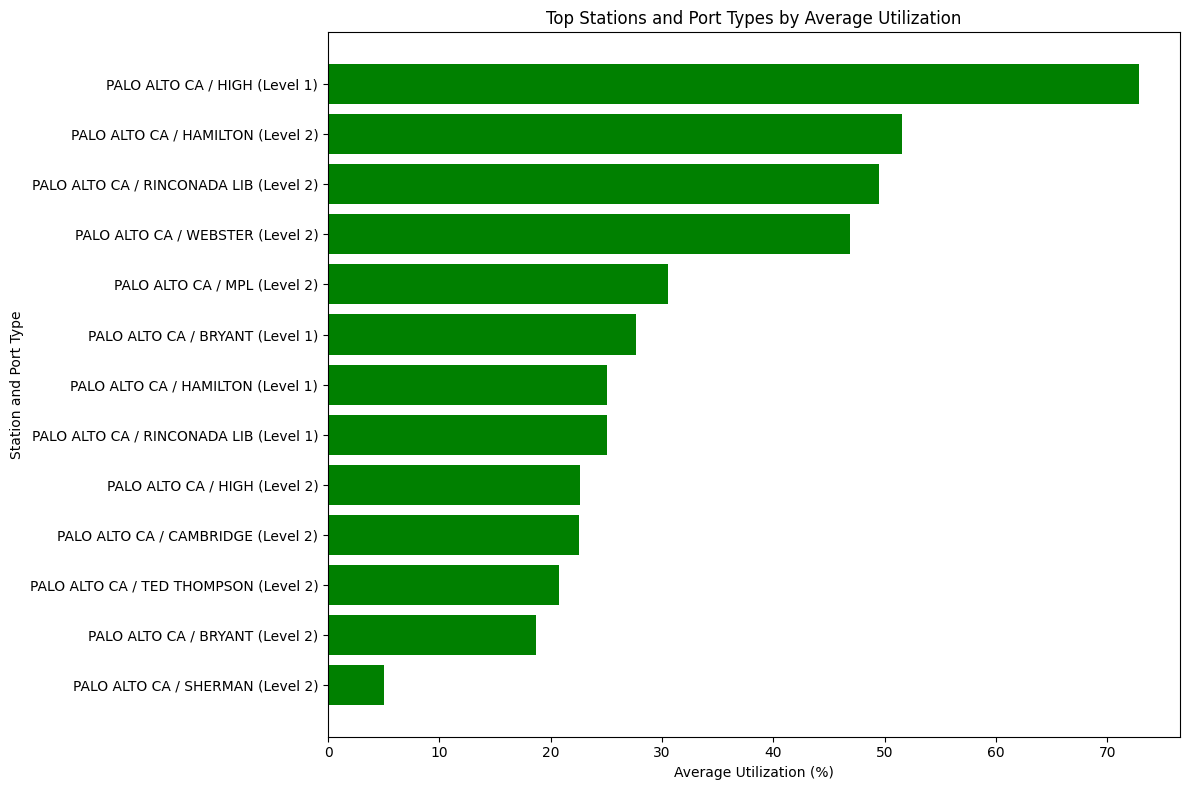

In [24]:
import matplotlib.pyplot as plt

# Combine Base Station Name and Port Type for y-axis labels
most_at_capacity['Station_Port'] = most_at_capacity['Base Station Name'] + " (" + most_at_capacity['Port Type'] + ")"

# Sort by Average Utilization to ensure proper order
most_at_capacity_sorted = most_at_capacity.sort_values('Average_Utilization', ascending=False)

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.barh(most_at_capacity_sorted['Station_Port'], most_at_capacity_sorted['Average_Utilization'], color='green')

# Add labels and title
plt.xlabel('Average Utilization (%)')
plt.ylabel('Station and Port Type')
plt.title('Top Stations and Port Types by Average Utilization')

# Flip the y-axis for better readability
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()


There is however, quite a large fluctuation from year to year, so doing a yearly analysis could be interesting.

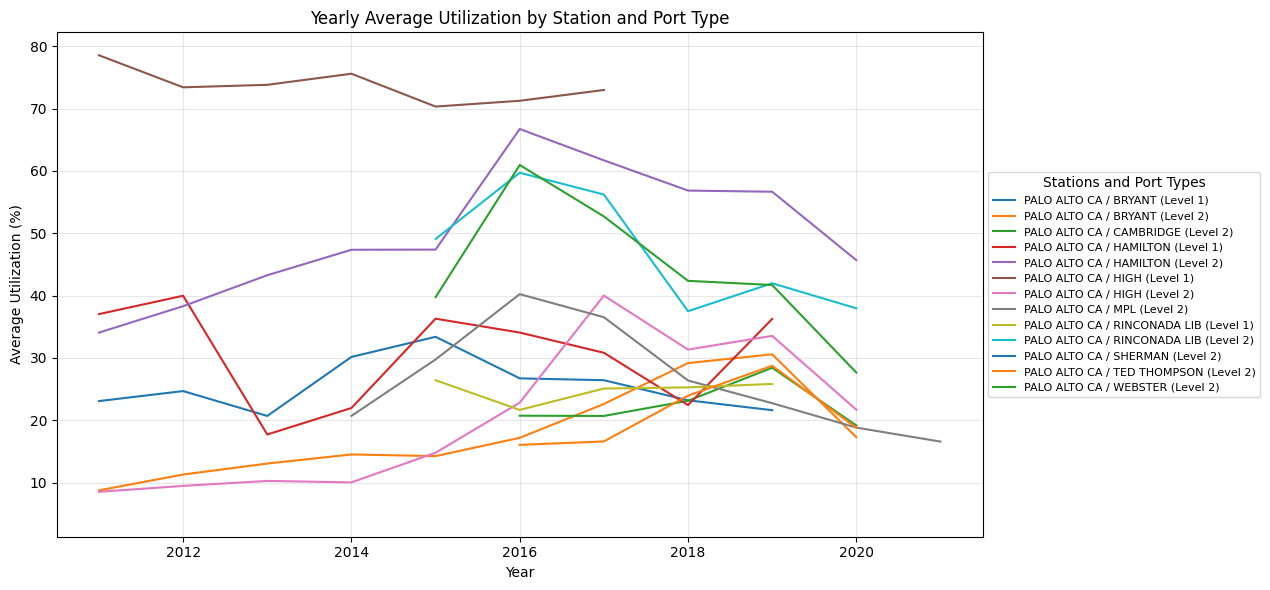

In [25]:
import matplotlib.pyplot as plt

# Ensure 'Date Pacific' is in datetime format
station_utilization_data['Date Pacific'] = pd.to_datetime(station_utilization_data['Date Pacific'])

# Extract year from the date
station_utilization_data['Year'] = station_utilization_data['Date Pacific'].dt.year

# Group by Base Station Name, Port Type, and Year, then calculate yearly average utilization
yearly_analysis = station_utilization_data.groupby(['Base Station Name', 'Port Type', 'Year']).agg(
    Average_Utilization=('Charger_Occupation_Sum_h', lambda x: (x / station_utilization_data['Total_Charging_Points']).mean() * 100)
).reset_index()

# Create a rectangular plot
plt.figure(figsize=(16, 6))  # Wider rectangle with increased width

# Iterate over unique stations and port types
for station_port in yearly_analysis.groupby(['Base Station Name', 'Port Type']):
    # Extract data for the specific station and port type
    station_name, port_type = station_port[0]
    station_port_data = station_port[1]
    
    # Plot
    plt.plot(station_port_data['Year'], station_port_data['Average_Utilization'], label=f'{station_name} ({port_type})')

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Average Utilization (%)')
plt.title('Yearly Average Utilization by Station and Port Type')

# Adjust the legend: Move it outside the plot
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5),  # Position it outside the plot on the right
    fontsize=8, 
    ncol=1,  # Single column for readability
    title='Stations and Port Types'
)

plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust the layout for space on the right

# Show the plot
plt.show()


Most of the upper lines here are Level 2 port types, except for the top one, which is level 1, but was most likely not in use after the year 2017.

Looking at the energy use at each base station could also be interesting.

# Add unit below

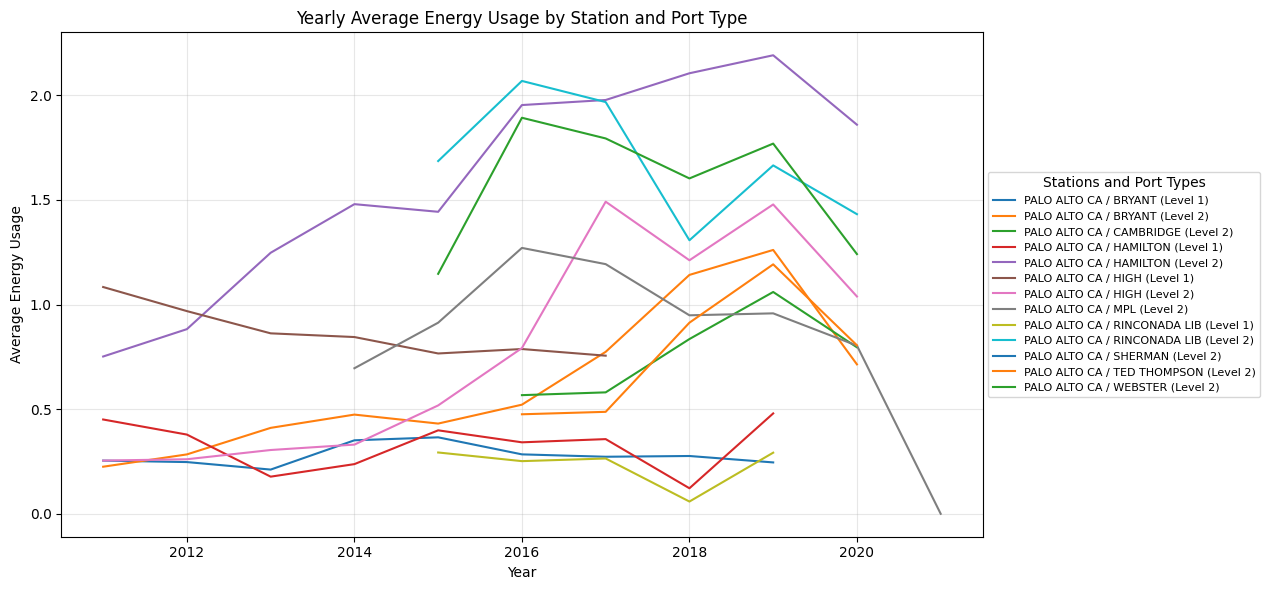

In [26]:
import matplotlib.pyplot as plt

# Ensure 'Date Pacific' is in datetime format
station_utilization_data['Date Pacific'] = pd.to_datetime(station_utilization_data['Date Pacific'])

# Extract year from the date
station_utilization_data['Year'] = station_utilization_data['Date Pacific'].dt.year

# Group by Base Station Name, Port Type, and Year, then calculate yearly average energy
yearly_analysis = station_utilization_data.groupby(['Base Station Name', 'Port Type', 'Year']).agg(
    Average_Energy=('Energy_Consumption_Sum_kWh', lambda x: (x / station_utilization_data['Total_Charging_Points']).mean())
).reset_index()

# Create a rectangular plot
plt.figure(figsize=(16, 6))  # Wider rectangle with increased width

# Iterate over unique stations and port types
for station_port in yearly_analysis.groupby(['Base Station Name', 'Port Type']):
    # Extract data for the specific station and port type
    station_name, port_type = station_port[0]
    station_port_data = station_port[1]
    
    # Plot
    plt.plot(station_port_data['Year'], station_port_data['Average_Energy'], label=f'{station_name} ({port_type})')

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Average Energy Usage')
plt.title('Yearly Average Energy Usage by Station and Port Type')

# Adjust the legend: Move it outside the plot
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5),  # Position it outside the plot on the right
    fontsize=8, 
    ncol=1,  # Single column for readability
    title='Stations and Port Types'
)

plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust the layout for space on the right

# Show the plot
plt.show()


The energy use shows similar trends, but it is clear here, that it is the Level 2 chargers that use the most energy, with HAMILTON being the top scorer. This could indicate that the Level 2 Port Type chargers are fast chargers.

This concludes the pre-analysis data visualization and cleanup.

# Exploratory Component Modelling

In this section, we are going to analyze the question:
- How can the company optimize its charging station infrastructure to reduce hoarding and increase utilization efficiency over time?

##### So, what is hoarding?
When a vehicle is plugged in, but is not charging (assumptively because it finished charging), we will define it as hoarding.

Under the assumptions:
- That charging is constant
- Price could be $0.23 per kWh, based on https://www.cityofpaloalto.org/Departments/Utilities/Sustainability/Electric-Vehicle
- Calculate a hoarding penalty price by taking around 20% of the average hourly price based on average hourly kWh and the price $0.23 per kWh.


In [47]:
# Calculate weighted average hourly price based on Hourly Energy Consumption (kWh) and Hourly Charger Occupation (h)
filtered_data = merged_data[
    (merged_data['Hourly Energy Consumption (kWh)'] > 0) & 
    (merged_data['Hourly Charger Occupation (h)'] > 0)
]

mean_ratio = (filtered_data['Hourly Energy Consumption (kWh)'] / filtered_data['Hourly Charger Occupation (h)']).mean()
print('Weighted average hourly consumption', mean_ratio)

# Multiplying this by the price of $0.23 per kWh gives:
hourly_price = mean_ratio * 0.23
print('Weighted hourly price', hourly_price)

# Using an hourly penalty price of 20% of the average hourly price gives:
hourly_penalty = hourly_price * 0.2
print('Hourly penalty price', hourly_penalty)

# This gives a minute penalty of:
minute_penalty = hourly_penalty / 60
print('Minute penalty price', minute_penalty)

# Funny realization: This gives 0.02 kr / min, which is the same as the minute fee for charging at a 
# 	Faroese EV Charging Station between 22 and 8. https://www.sev.fo/um-okkum/toel-treytir-og-fragreidingar/prisir

# Figure out lost revenue by summing the 'Plugged_In_Not_Charging_Sum_h' and multiplying this with the hourly penalty price.
total_hoarding = station_utilization_data['Plugged_In_Not_Charging_Sum_h'].sum()
lost_potential_revenue = total_hoarding * hourly_penalty
print('Lost Potential Revenue $', round(lost_potential_revenue, 2))

# Total revenue, with the price we've chosen, of $0.23.
total_kWh = station_utilization_data['Energy_Consumption_Sum_kWh'].sum()
total_revenue = total_kWh * 0.23
print('Total Revenue $', round(total_revenue, 2))

# Percentage increase gained by charging for hoarding according to the proposed prices
percentage_increase = lost_potential_revenue / total_revenue * 100
print('Percentage increase in sales', round(percentage_increase, 2), '%')

Weighted average hourly consumption 4.030852313870766
Weighted hourly price 0.9270960321902763
Hourly penalty price 0.18541920643805526
Minute penalty price 0.003090320107300921
Lost Potential Revenue $ 22422.74
Total Revenue $ 490298.01
Percentage increase in sales 4.57 %


In [43]:
station_utilization_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339597 entries, 0 to 339596
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype                     
---  ------                         --------------   -----                     
 0   Base Station Name              339597 non-null  object                    
 1   Port Type                      339597 non-null  object                    
 2   Date Pacific                   339597 non-null  datetime64[ns, US/Pacific]
 3   Energy_Consumption_Sum_kWh     339597 non-null  float64                   
 4   Charger_Occupation_Sum_h       339597 non-null  float64                   
 5   Plugged_In_Not_Charging_Sum_h  339597 non-null  float64                   
 6   Plugged_In_Charging_Sum_h      339597 non-null  float64                   
 7   Total_Charging_Points          339597 non-null  int64                     
 8   Latitude                       339597 non-null  float64                   
 9   Long

### Boxplots to check seasonality

#### Month

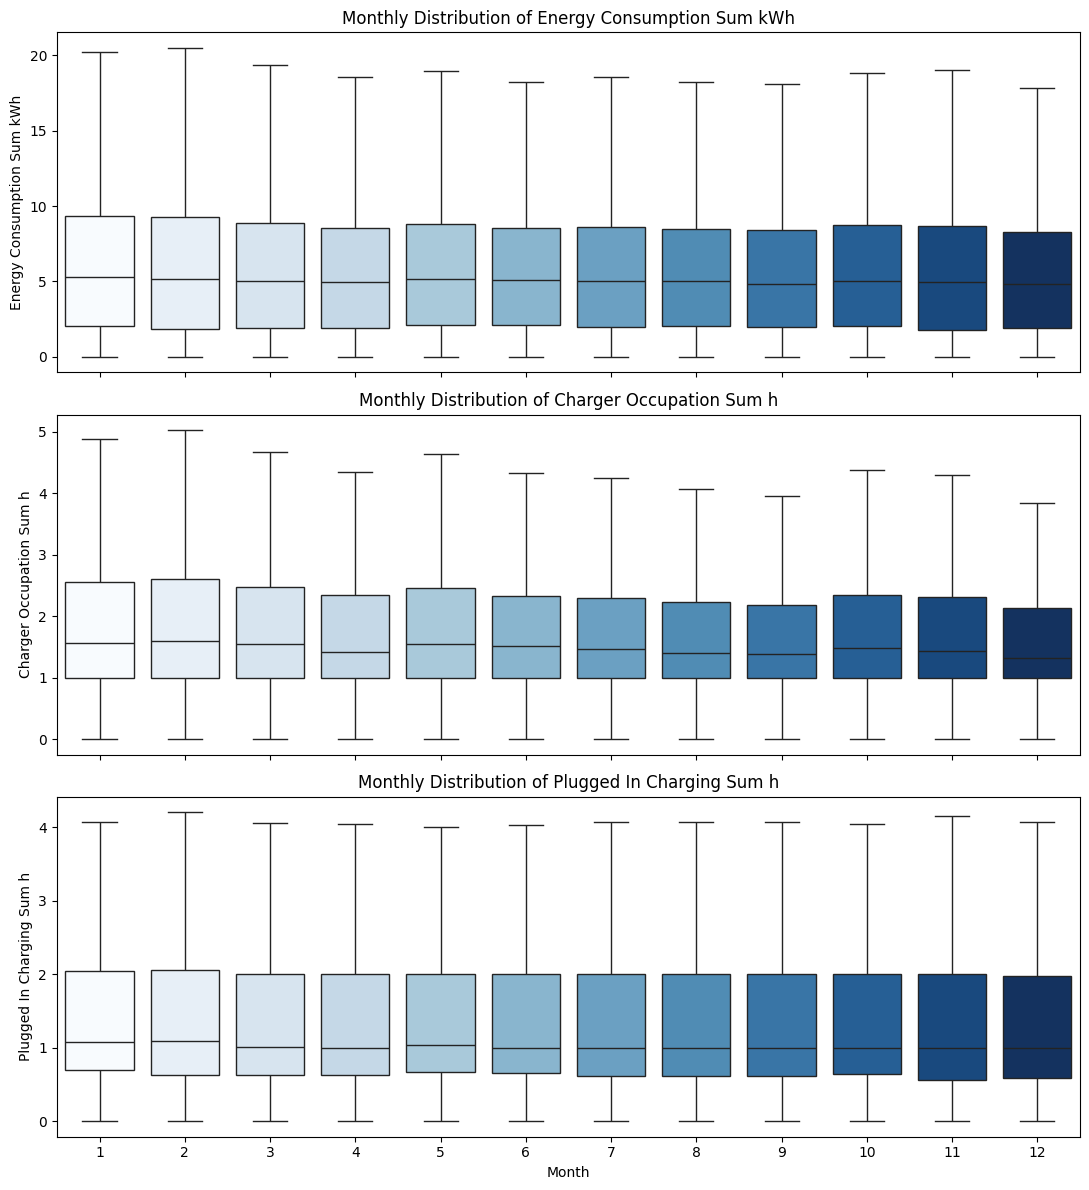

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for Month
station_utilization_data['Month'] = station_utilization_data['Date Pacific'].dt.month

# Variables to plot
variables = ['Energy_Consumption_Sum_kWh', 'Charger_Occupation_Sum_h', 'Plugged_In_Charging_Sum_h']

# Create subplots
fig, axes = plt.subplots(len(variables), 1, figsize=(11, 12), sharex=True)

for var, ax in zip(variables, axes):
    sns.boxplot(
        data=station_utilization_data, 
        x='Month', 
        y=var, 
        ax=ax, 
        hue='Month',  # Assign hue to match x
        palette='Blues', 
        dodge=False,  # Ensure boxes are not split by hue
        showfliers=False  # Optional: Hide outliers for cleaner visualization
    )
    ax.set_ylabel(var.replace('_', ' '))
    ax.set_title(f'Monthly Distribution of {var.replace("_", " ")}')
    ax.set_xlabel('Month' if ax == axes[-1] else '')  # Label x-axis only on the last subplot
    ax.legend_.remove()  # Remove legend for a cleaner look

plt.tight_layout()
plt.show()


#### Day vs night

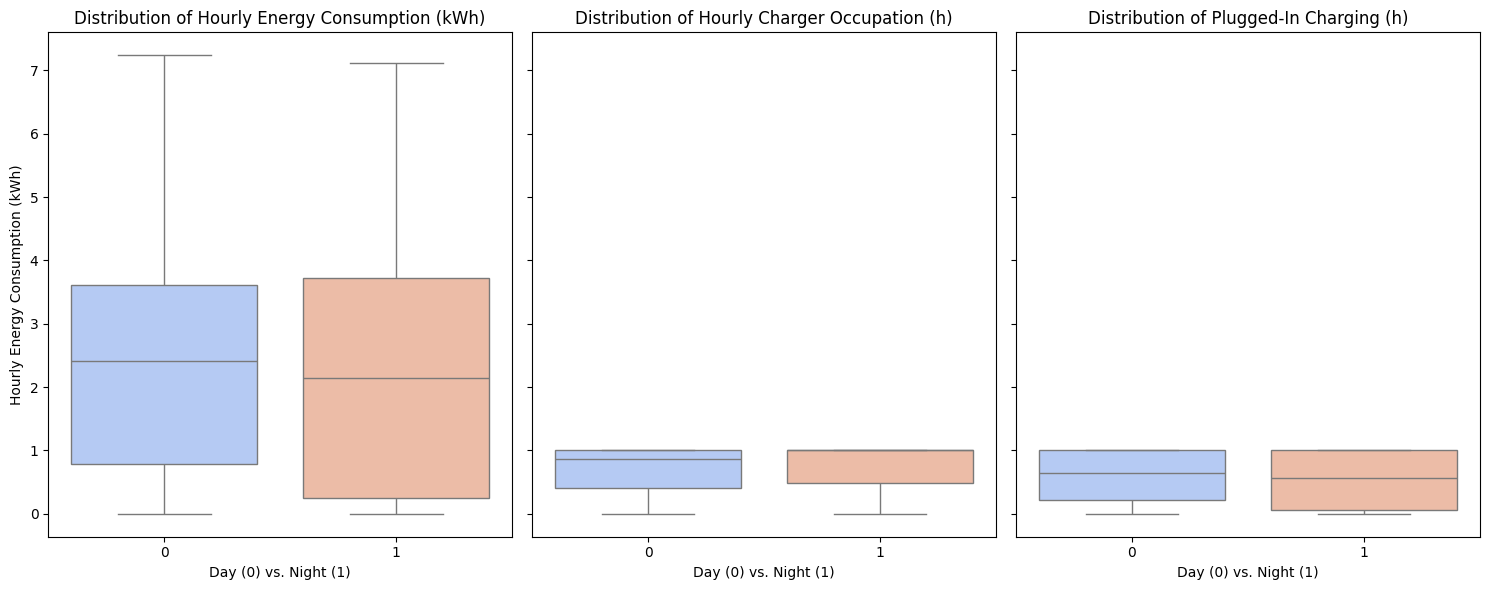

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables to plot
variables = ['Hourly Energy Consumption (kWh)', 'Hourly Charger Occupation (h)', 'Plugged-In Charging (h)']

# Create subplots with one row and multiple columns
fig, axes = plt.subplots(1, len(variables), figsize=(15, 6), sharey=True)

for var, ax in zip(variables, axes):
    sns.boxplot(
        data=merged_data, 
        x='Is Night',  # Use day/night distinction
        y=var, 
        ax=ax, 
        hue='Is Night',  # Add hue to differentiate between day and night
        palette='coolwarm', 
        dodge=False, 
        showfliers=False  # Optional: Hide outliers for cleaner visualization
    )
    ax.set_ylabel(var.replace('_', ' '))
    ax.set_title(f'Distribution of {var.replace("_", " ")}')
    ax.set_xlabel('Day (0) vs. Night (1)')
    ax.legend_.remove()  # Remove legend for a cleaner look

plt.tight_layout()
plt.show()


#### Weekday vs weekend

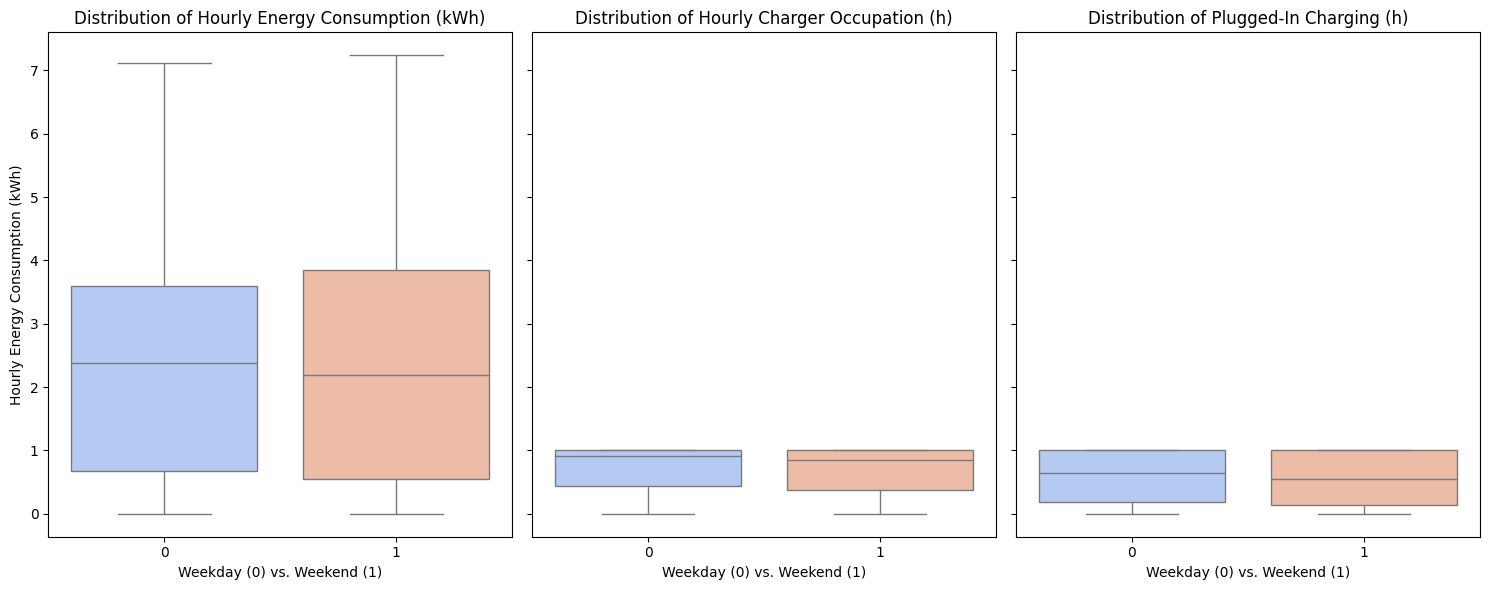

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables to plot
variables = ['Hourly Energy Consumption (kWh)', 'Hourly Charger Occupation (h)', 'Plugged-In Charging (h)']

# Create subplots with one row and multiple columns
fig, axes = plt.subplots(1, len(variables), figsize=(15, 6), sharey=True)

for var, ax in zip(variables, axes):
    sns.boxplot(
        data=merged_data, 
        x='Is Weekend',  # Use weekday/weekend distinction
        y=var, 
        ax=ax, 
        hue='Is Weekend',  # Add hue to differentiate between weekday (0) and weekend (1)
        palette='coolwarm', 
        dodge=False, 
        showfliers=False  # Optional: Hide outliers for cleaner visualization
    )
    ax.set_ylabel(var.replace('_', ' '))
    ax.set_title(f'Distribution of {var.replace("_", " ")}')
    ax.set_xlabel('Weekday (0) vs. Weekend (1)')
    ax.legend_.remove()  # Remove legend for a cleaner look

plt.tight_layout()
plt.show()
